<a href="https://colab.research.google.com/github/ahshawaf/AML/blob/project6/Project6_Team1_Ahmad_Celeba.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# Common Import
import sklearn
import pandas as pd
import numpy as np
from sklearn import metrics
import seaborn as sns
import os
import time
import random

import tarfile
import cv2
from google.colab.patches import cv2_imshow

# to make this notebook's output stable across runs
np.random.seed(42)

from zipfile import ZipFile


from sklearn.decomposition import PCA
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler,LabelEncoder

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore")

# sklearn version > 0.20 is required 
sklearn.__version__
# Update sklearn -> !pip install -U scikit-learn

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


'0.22.2.post1'

#Custom Functions

This is a fucntion to download a file using **URL**. Then save it in the **save_path** with **target_file_name**. If target_file_name is empty, then the file name will be gotten from the URL.

In [0]:
import urllib
import urllib.parse as parse

def download(url,save_path,target_file_name=''):
  print("file is being downloading from {} ...".format(url))
  file = urllib.request.urlopen(url)
  fileData = file.read()

  if target_file_name=='':
    split=parse.urlsplit(url)
    target_file_name = split.path.split('/')[-1]
  
  if not os.path.exists(save_path):
    os.mkdir(save_path)

  targetFile = os.path.join(save_path,target_file_name)
  with open(targetFile,'wb') as f:
    f.write(fileData)
  print('Done, file in the path {}'.format(targetFile))

This is a function to extract tar file in the **tar_file_path**, which includes the file name and the extension, to **target_path**.

In [0]:
def extractTar(tar_file_path,target_path):
    print("Extracting is starting....")
    tar=tarfile.open(tar_file_path)
    tar.extractall(target_path)
    tar.close()
    print("Done")

This is a function to extract zip file in the **zip_file_path**, which includes the file name and the extension, to **target_path**.

In [0]:
def extractZip(zip_file_path,target_path):
    print("Extracting is starting....")
    zFile=ZipFile(zip_file_path)
    zFile.extractall(target_path)
    zFile.close()
    print("Done")

This is a custom function to create a imgs set without labels, unsupervised dataset. It used the folder path of the imgs.

In [0]:
def create_img_set(imgs_folder_path):
  x=[]
  lst = os.listdir(imgs_folder_path)
  for img in lst:
    img_imr = cv2.imread(os.path.join(imgs_folder_path,img))
    img_imr = cv2.resize(img_imr,(32,32))
    x.append(np.array(img_imr))
  return x

randomly_sho_imgs is for randomly display nrows x ncols images from the training set 

In [0]:
def randomly_show_imgs(x_set,nrows,ncols):
  plt.figure(figsize=(10,10))
  for i in range(nrows*ncols):
    plt.subplot(nrows,ncols,i+1)
    indx = random.randint(0,len(x_set))
    plt.imshow(x_set[indx])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
  plt.show()

plot_data is to generate a plot chart from the x data

In [0]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

plot_centroids to generate a plot chart with the centers point passed

In [0]:
def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)

plot_decision_boundaries is to generate a Voronoi diagram:

In [0]:
def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

plot_gaussian_mixture is to generate a plot chart for gaussian_mixture

In [0]:
from matplotlib.colors import LogNorm

def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

create the following directeries to save the **downsampled and celeba datasets**

In [0]:
root_path = 'data'
if not os.path.exists(root_path):
  os.mkdir(root_path)

downsampled_path = os.path.join(root_path,'downsampled')
if not os.path.exists(downsampled_path):
  os.mkdir(downsampled_path)

celeba_path = os.path.join(root_path,'celeba')
if not os.path.exists(celeba_path):
  os.mkdir(celeba_path)


#Loading Downsampled Dataset

here, the celeba data will be downloaded to the path 'data/celeba'



In [12]:
url = 'https://storage.googleapis.com/kaggle-data-sets/591568/1066047/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1586578463&Signature=MpjyYG9vibDTKL%2BL8llqi9%2Fbnk0JDjDSGv8%2B7XFCjIzKYGtb0n6XPDK30ppsXQo4PrmYGNKdhpSGDqPDZATtXDntrQnmnaIO%2BnNUj8Zan6rCnRd1rYEFqKFE3%2B2a85njQY97bbFr4A%2FYZ3GslMhL53%2BVGp1%2F5RM92Gdl2%2FVjyB%2BAfZKzqzCZsb9jALLLK6vUfZI4Ltc2qiCId%2BOc%2B%2FfP8RUAOFA7Z5Qebms%2BgudRNSb9a61l%2FeaH9iXrXZG5RSmJEFUmorkuOoRXrXIodbb96HFCJ%2BiD5JfXB43Rcl3CHagokBPr3joXLIujxm9nDL%2BF2U7qBE5gVSQf1aY06q%2FVHA%3D%3D&response-content-disposition=attachment%3B+filename%3Dceleba.zip'
save_path = celeba_path
download(url,save_path=save_path,target_file_name='celeba.zip')

file is being downloading from https://storage.googleapis.com/kaggle-data-sets/591568/1066047/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1586578463&Signature=MpjyYG9vibDTKL%2BL8llqi9%2Fbnk0JDjDSGv8%2B7XFCjIzKYGtb0n6XPDK30ppsXQo4PrmYGNKdhpSGDqPDZATtXDntrQnmnaIO%2BnNUj8Zan6rCnRd1rYEFqKFE3%2B2a85njQY97bbFr4A%2FYZ3GslMhL53%2BVGp1%2F5RM92Gdl2%2FVjyB%2BAfZKzqzCZsb9jALLLK6vUfZI4Ltc2qiCId%2BOc%2B%2FfP8RUAOFA7Z5Qebms%2BgudRNSb9a61l%2FeaH9iXrXZG5RSmJEFUmorkuOoRXrXIodbb96HFCJ%2BiD5JfXB43Rcl3CHagokBPr3joXLIujxm9nDL%2BF2U7qBE5gVSQf1aY06q%2FVHA%3D%3D&response-content-disposition=attachment%3B+filename%3Dceleba.zip ...
Done, file in the path data/celeba/celeba.zip


Extract the celeba  dataset to the path data/celeba/imgs/

In [13]:
extractZip(os.path.join(celeba_path,'celeba.zip'),os.path.join(celeba_path,'imgs'))

Extracting is starting....
Done


#Exploring Data 

list randomly 10 images of the training data

In [14]:
main_path = os.path.join(celeba_path,'imgs/img_align_celeba')

clb_lst=os.listdir(main_path)
len(clb_lst)

202599

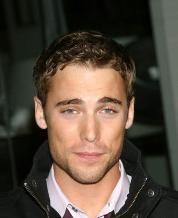

image size (218, 178, 3) 


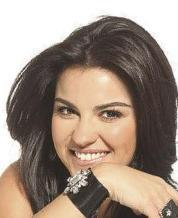

image size (218, 178, 3) 


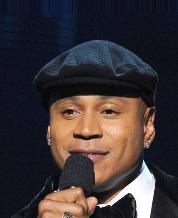

image size (218, 178, 3) 


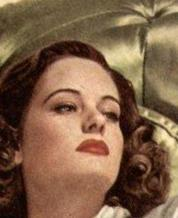

image size (218, 178, 3) 


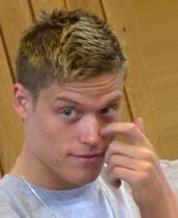

image size (218, 178, 3) 


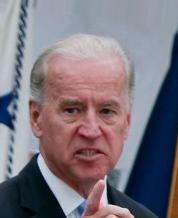

image size (218, 178, 3) 


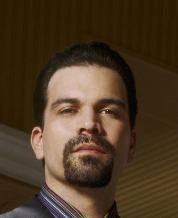

image size (218, 178, 3) 


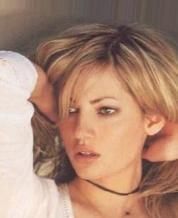

image size (218, 178, 3) 


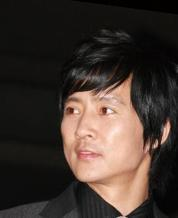

image size (218, 178, 3) 


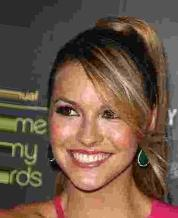

image size (218, 178, 3) 


In [15]:
for i in range(10):
  rndIndx=random.randint(0,len(clb_lst)-1)
  imgPath = os.path.join(main_path,clb_lst[rndIndx])
  img=cv2.imread(imgPath)
  cv2_imshow(img)
  print('image size {} '.format(img.shape))
   

#Creating Training Set

In [0]:
celeba_imgs_folder_path = os.path.join(celeba_path,'imgs/img_align_celeba')
clb_x= create_img_set(celeba_imgs_folder_path)

In [17]:
len(clb_x)

202599

Show randomly 25 images from the training set

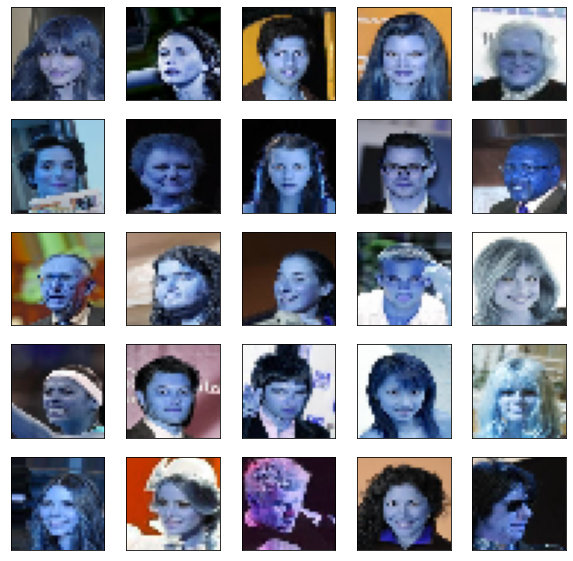

In [18]:
randomly_show_imgs(clb_x,5,5)

#Flatten the set

convert first the dsp_x from list to numpy array

In [0]:
clb_x_npa = np.array(clb_x)

In [20]:
clb_x_npa.shape

(202599, 32, 32, 3)

Convert the data from (202599, 32, 32, 3) to (202599, 3072) which is (202599, 32x32x3)

In [0]:
rows=int(clb_x_npa.shape[0])
cols=int(clb_x_npa.shape[1]*clb_x_npa.shape[2]*clb_x_npa.shape[3])
clb_x_npa=clb_x_npa.reshape(rows,cols)

In [22]:
clb_x_npa.shape

(202599, 3072)

#Clustring

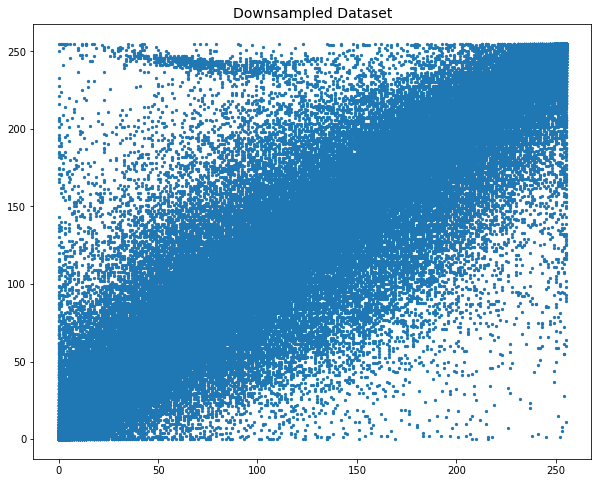

In [23]:
plt.figure(figsize=(10,8))
plt.scatter(clb_x_npa[:,0],clb_x_npa[:,1],s=5)
plt.title('Downsampled Dataset',fontsize =14)
plt.show()

Creatgin blobs samples

In [0]:
clb_x_blob, clb_y_blob=make_blobs(n_samples=len(clb_x_npa),random_state=47)

Display the distinct labels

In [25]:
np.unique(clb_y_blob)

array([0, 1, 2])

In [26]:
clb_y_blob.shape

(202599,)

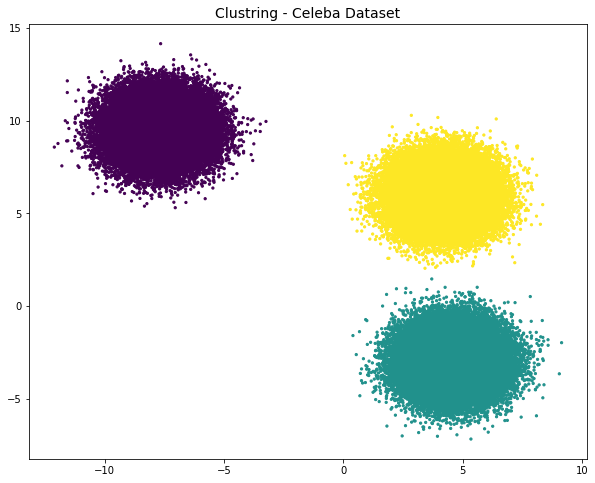

In [27]:
plt.figure(figsize=(10,8))
plt.scatter(clb_x_blob[:,0],clb_x_blob[:,1],c=clb_y_blob,s=5)
plt.title('Clustring - Celeba Dataset',fontsize = 14)
plt.show()

#Plot K-elbow

Using a subset with 10,000 rows for running fast as the entire data is 202,599 which is huge. It takes long time to excute the code


In [0]:
clb_range=range(1,10)
clb_kmeans=[KMeans(n_clusters=k,random_state=47).fit(clb_x_blob[:10000]) for k in clb_range]
inertias = [model.inertia_ for model in clb_kmeans]

Text(0.5, 1.0, 'K - Elbow for Celeba')

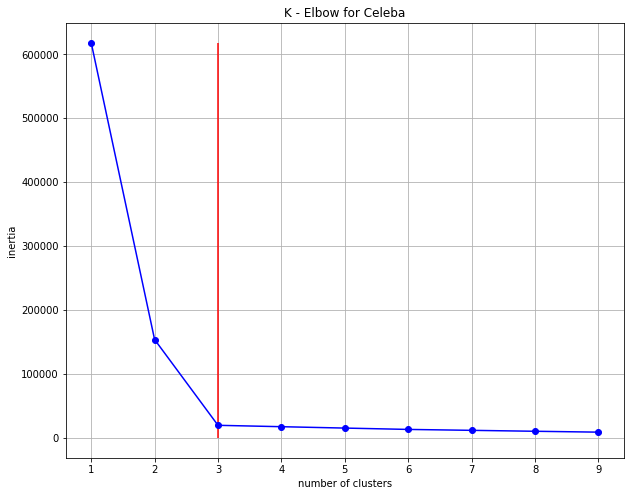

In [29]:
plt.figure(figsize=(10,8))
plt.plot(clb_range,inertias,'bo-')
plt.xlabel("number of clusters")
plt.ylabel("inertia")
plt.grid(True)
plt.vlines(3,0,np.max(inertias),color='red')
plt.title("K - Elbow for Celeba")

from the elbow chart, the number of cluster is 3 is most suitable.

#Plot the silhouette score vs performance of k

In [0]:
clb_silhouette_score= [silhouette_score(clb_x_blob[:10000],model.labels_) for model in clb_kmeans[1:]]
clb_best_indx = np.argmax(clb_silhouette_score)
clb_best_score = clb_silhouette_score[clb_best_indx]
clb_best_model = clb_kmeans[1:][clb_best_indx]

because the clb_kmeans is passed starting from index 1 not zero. Also, the resturn index for clb_best_indx starts from 0. So, 2 is added to the index

In [0]:
clb_number_of_cluster = clb_best_indx + 2

Text(0.5, 1.0, 'Performance of $K$ for Celeba')

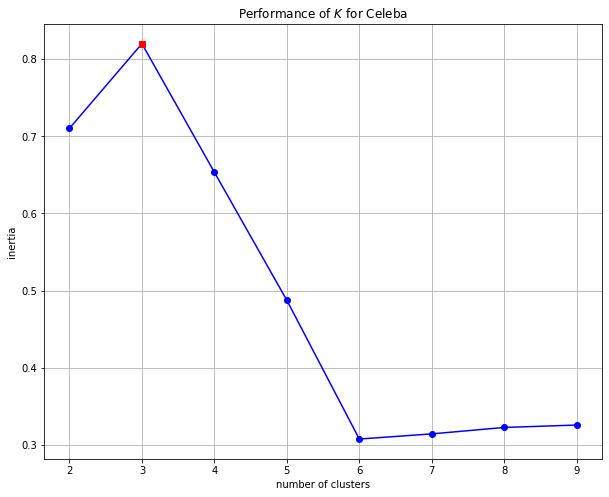

In [32]:
plt.figure(figsize=(10,8))
plt.plot(range(2,10),clb_silhouette_score,'bo-')
plt.xlabel("number of clusters")
plt.ylabel("inertia")
plt.grid(True)
plt.plot(clb_number_of_cluster,clb_best_score,'rs')
plt.title("Performance of $K$ for Celeba")

This visualization is clear to confirms that $k=3$ is the best choice.

#K-Means Clustering



###Fit and Predict

Let's train a K-Means clusterer on this dataset. It will try to find each blob's center and assign each instance to the closest blob:

In [0]:
kmodel = KMeans(n_clusters=3, random_state=42)

In [0]:
y = kmodel.fit_predict(clb_x_blob)

In [35]:
y

array([2, 1, 2, ..., 0, 2, 2], dtype=int32)

In [36]:
np.unique(y)

array([0, 1, 2], dtype=int32)

In [37]:
len(y)

202599

In [38]:
y is kmodel.labels_

True

Therefore, y_pred is the label (0, 1, 2) tha represents for each cluster.

Note that the KMeans instance preserves the labels of the instances it was trained on. Somewhat confusingly, in this context, the label of an instance is the index of the cluster that instance gets assigned to:

In [39]:
kmodel.labels_

array([2, 1, 2, ..., 0, 2, 2], dtype=int32)

Of course, we can predict the labels of new instances:

###Decision Boundaries


Let's plot the model's decision boundaries. This gives us a Voronoi diagram

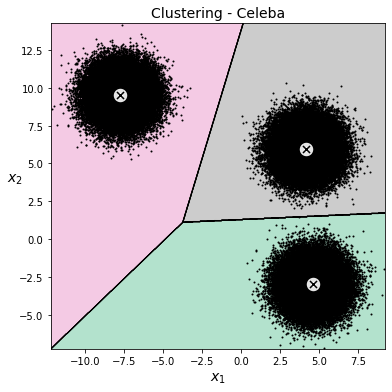

In [40]:
plt.figure(figsize=(6, 6))
plot_decision_boundaries(kmodel, clb_x_blob)
plt.title("Clustering - Celeba", fontsize=14)
plt.show()

#With RandomForest Classifier



###Spliting data for training and testing set in ratio 70%-30%

In [0]:
clb_x_train, clb_x_test, clb_y_train, clb_y_test = train_test_split(clb_x_blob, y, test_size=0.3, shuffle = True, random_state=42)

In [42]:
clb_x_train.shape, clb_y_train.shape, clb_x_test.shape, clb_y_test.shape

((141819, 2), (141819,), (60780, 2), (60780,))


Create the model and fit with the training set

In [43]:
from sklearn.ensemble import RandomForestClassifier

RF_clb = RandomForestClassifier(random_state=42)
RF_clb.fit(clb_x_train, clb_y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Perform cross validation using subset size 500

In [44]:
cross_val_score(RF_clb, clb_x_test, clb_y_test, cv=3, scoring='accuracy').mean()

1.0

Test the model using testing set

In [46]:
RF_clb.score(clb_x_test, clb_y_test)

1.0

See the predict score

In [47]:
y_pred = RF_clb.predict(clb_x_blob)
y_pred

array([2, 1, 2, ..., 0, 2, 2], dtype=int32)

In [48]:
accuracy_score(y, y_pred)

1.0

See the confustion matrix

In [49]:
labels= np.unique(kmodel.labels_)
labels

array([0, 1, 2], dtype=int32)

Text(0.5, 1.0, 'Confusion Matrix')

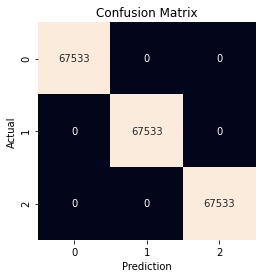

In [50]:
mat = confusion_matrix(y_pred, y)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=labels,
            yticklabels=labels)
plt.xlabel('Prediction')
plt.ylabel('Actual');
plt.title('Confusion Matrix')

See how RF classify the first 25 images

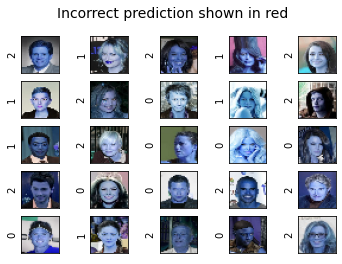

In [51]:
fig, ax = plt.subplots(5, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(clb_x[i])
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(str(labels[y_pred[i]]).split()[-1],
                   color='black' if y_pred[i] == y[i] else 'red')
fig.suptitle('Incorrect prediction shown in red', size=14);


There's no red number popup, that mean 100% rate prediction as expected.

#Use K-Means as a dimensionality reduction tool and train a classifier on the reduced set


In [0]:
X_train_reduced = clb_best_model.transform(clb_x_train)
X_test_reduced = clb_best_model.transform(clb_x_test)

In [57]:
X_train_reduced.shape,X_test_reduced.shape

((141819, 3), (60780, 3))

Perform cross validation using subset size 500

In [58]:
cross_val_score(RF_clb, clb_x_test[:500], clb_y_test[:500], cv=3, scoring='accuracy').mean()

1.0


Fit to training model

In [59]:
RF_clb.fit(X_train_reduced, clb_y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Test the model using testing set

In [60]:
RF_clb.score(X_test_reduced, clb_y_test)

1.0

The accuracy is same with reduction or not

#With Gaussian Mixtures

Apply PCA (99% variataion)

In [0]:
pca = PCA(n_components=0.99)
X_clb_pca = pca.fit_transform(clb_x_npa)

In [0]:
X_clb_pca.shape

Let's train a Gaussian mixture model on the training set

In [0]:

from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=3, n_init=10, random_state=42)
gm.fit(X_clb_pca)


Let's look at the parameters that the EM algorithm estimated:

In [0]:
gm.weights_

In [0]:
gm.means_

Did the algorithm actually converge?

In [0]:
gm.converged_

Yes, good. How many iterations did it take?

In [0]:
gm.n_iter_

You can now use the model to predict which cluster each instance belongs to (hard clustering) or the probabilities that it came from each cluster.

In [0]:
gm.predict(X_clb_pca)


Now let's plot the resulting decision boundaries (dashed lines) and density contours:

In [0]:
plt.figure(figsize=(8, 4))
plot_gaussian_mixture(gm, X_clb_pca)
plt.show()

#Search for the number of clusters that provides the best performance.

In [0]:
from sklearn.pipeline import Pipeline
#This list to be used for visualization
pipe_clb_scores = []
for n_clusters in range(1,11):
    pipe_dsp = Pipeline([
        ("kmeans", KMeans(n_clusters=n_clusters, random_state=42)),
        ("forest_clf", RandomForestClassifier(n_estimators=100, random_state=42))
    ])
    
    pipe_dsp.fit(clb_x_train, clb_y_train)

    pipe_clb_scores.append([])
    pipe_clb_scores[n_clusters-1].append(n_clusters)
    score = pipe_dsp.score(clb_x_test, clb_y_test)
    pipe_clb_scores[n_clusters-1].append(score)
    
    print(n_clusters, score)


This can be seen clearly that, n_clusters = 3 provides the best performance.

#Anomaly Detection using Gaussian Mixtures

Gaussian Mixtures can be used for anomaly detection: instances located in low-density regions can be considered anomalies. You must define what density threshold you want to use. For example, in a manufacturing company that tries to detect defective products, the ratio of defective products is usually well-known. Say it is equal to 4%, then you can set the density threshold to be the value that results in having 4% of the instances located in areas below that threshold density:

In [0]:
densities = gm.score_samples(X_clb_pca)
density_threshold = np.percentile(densities, 4)
anomalies = X_clb_pca[densities < density_threshold]

In [0]:
plt.figure(figsize=(8, 6))

plot_gaussian_mixture(gm, X_clb_pca)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*')
plt.ylim(top=5.1)
plt.show()